# Calculate hourly capacity factor

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = "00:20:00"
cores = 48
memory = str(4 * cores) + "GB"

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=["-q normal",
                                           "-P w42",
                                           "-l ncpus="+str(cores),
                                           "-l mem="+str(memory),
                                           "-l storage=gdata/w42+gdata/rt52"],
                     local_directory="$TMPDIR",
                     job_directives_skip=["select"])

/g/data/w42/dr6273/apps/conda/envs/ml_env/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46651 instead
  warnings.warn(


In [3]:
cluster.scale(jobs=3)
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/46651/status,
Dashboard: /proxy/46651/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.20:37651,Workers: 0
Dashboard: /proxy/46651/status,Total threads: 0
Started: 1 minute ago,Total memory: 0 B


In [5]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

In [6]:
%cd /g/data/w42/dr6273/work/energy_climate_modes

import functions as fn

/g/data/w42/dr6273/work/energy_climate_modes


In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
load_path = "/g/data/w42/dr6273/work/data/era5/100w/hourly/"

In [9]:
w100 = xr.open_mfdataset(
    load_path + "*.nc",
)["w100"]

# Calculate wind capacity factor using Gunn method

In [30]:
def capacity_factor(W):
    """
    Computes capacity factor from wind speed data.
    
    W: wind speed (m/s)
    """
    W_0 = 3 # cut-in speed (m/s)
    W_1 = 30 # cut-out speed (m/s)
    
    # Turbine parameters
    Betz_c = 16 / 27 # Betz constant, setting theoretical maximum power extraction
    rho_f = 1.2 # air density (kg/m^3)
    L = 125 / 2 # turbine blade length (m)
    e = 0.65 # typical turbine efficiency
    C = 5e+6 # typical modern turbine rated capacity (W)
    
    A = Betz_c * rho_f * np.pi * (L ** 2) * e / (2 * C)
    
    # f = A * (W - W_0) ** 3 # cubic power curve (INCORRECT, Gunn pers comm)
    f = A * W ** 3 # cubic power curve
    g = xr.ones_like(W)
    
    beta = 5 # sets sharpness of transition between f and g
    
    # Capacity factor
    c_f = (f ** -beta + g ** -beta) ** (-1 / beta) # spline to combine f and g
    c_f = c_f.where(# Wind speeds above cut-off have zero power
        (W < W_1),
        0
    )
    c_f = c_f.where(# Wind speeds below cut-in have zero power
        (W >= W_0),
        0
    )
    c_f = c_f.fillna(0)
    c_f = c_f.where(W.notnull(), np.nan) # Ensure NaNs are retained
    
    return c_f

In [32]:
def capacity_factor2(W):
    """
    Computes capacity factor from wind speed data.
    
    W: wind speed (m/s)
    """
    W_0 = 3 # cut-in speed (m/s)
    W_1 = 30 # cut-out speed (m/s)
    
    # Turbine parameters
    Betz_c = 16 / 27 # Betz constant, setting theoretical maximum power extraction
    rho_f = 1.2 # air density (kg/m^3)
    L = 125 / 2 # turbine blade length (m)
    e = 0.65 # typical turbine efficiency
    C = 5e+6 # typical modern turbine rated capacity (W)
    
    A = Betz_c * rho_f * np.pi * (L ** 2) * e / (2 * C)
    
    # f = A * (W - W_0) ** 3 # cubic power curve (INCORRECT, Gunn pers comm)
    f = A * W ** 3 # cubic power curve
    g = xr.ones_like(W)
    
    beta = 5 # sets sharpness of transition between f and g
    
    # Capacity factor
    c_f = (f ** -beta + g ** -beta) ** (-1 / beta) # spline to combine f and g
    c_f = c_f.where(# Wind speeds above cut-off have zero power
        (W < W_1),
        0
    )
    # c_f = c_f.where(# Wind speeds below cut-in have zero power
    #     (W >= W_0),
    #     0
    # )
    c_f = c_f.fillna(0)
    c_f = c_f.where(W.notnull(), np.nan) # Ensure NaNs are retained
    
    return c_f

In [11]:
gunn_cf = capacity_factor(w100)

In [12]:
gunn_cf = gunn_cf.chunk({"time": 365*10})

In [13]:
gunn_cf = gunn_cf.to_dataset(name="wind_cf")

In [14]:
write_path = "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/"

gunn_cf.to_zarr(
    write_path + "wind_capacity_factor_Gunn_era5_hourly_1959-2022_Aus.zarr",
    mode="w",
    consolidated=True
)

In [15]:
gunn_cf = xr.open_zarr(
    write_path + "wind_capacity_factor_Gunn_era5_hourly_1959-2022_Aus.zarr",
    consolidated=True
)

### Average capacity factor

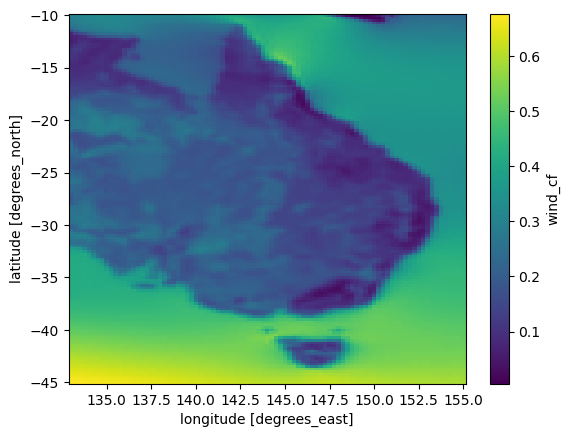

In [16]:
gunn_cf["wind_cf"].mean("time").plot()

### 2014-2015 time series for near Sydney

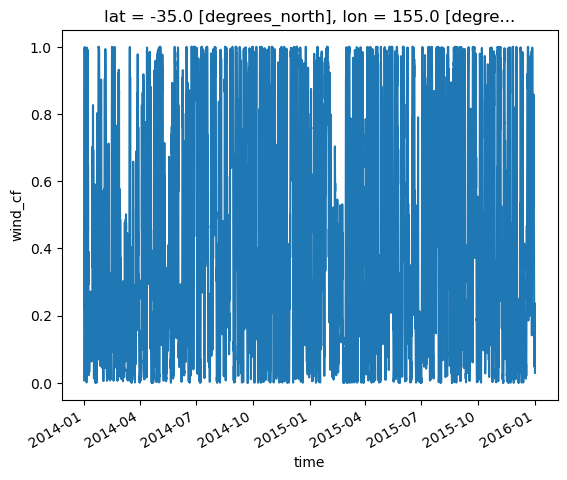

In [17]:
gunn_cf["wind_cf"].sel(lat=-35, lon=155, time=slice("2014", "2015")).plot()

Text(0, 0.5, 'Capacity factor [-]')

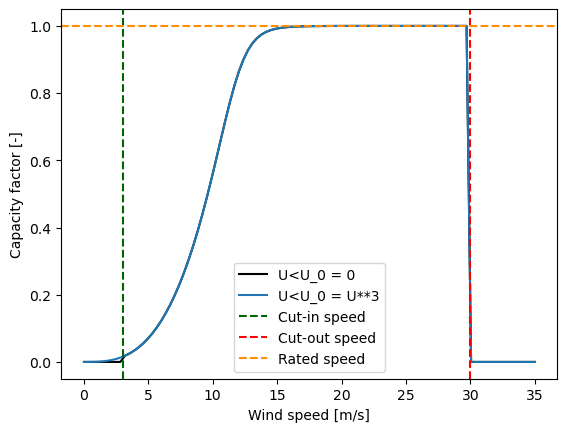

In [35]:
x = xr.DataArray(np.linspace(0, 35, 100))
p = capacity_factor(x)
p2 = capacity_factor2(x)

fig, ax = plt.subplots(1, 1)
ax.plot(x, p, label="U<U_0 = 0", c="k")
ax.plot(x, p2, label="U<U_0 = U**3")
ax.axvline(3, ls="--", color="darkgreen", label="Cut-in speed")
ax.axvline(30, ls="--", color="r", label="Cut-out speed")
ax.axhline(1, ls="--", color="darkorange", label="Rated speed")
ax.legend()
ax.set_xlabel("Wind speed [m/s]")
ax.set_ylabel("Capacity factor [-]")

# Try alternative capacity factor from van der Wiel 2019

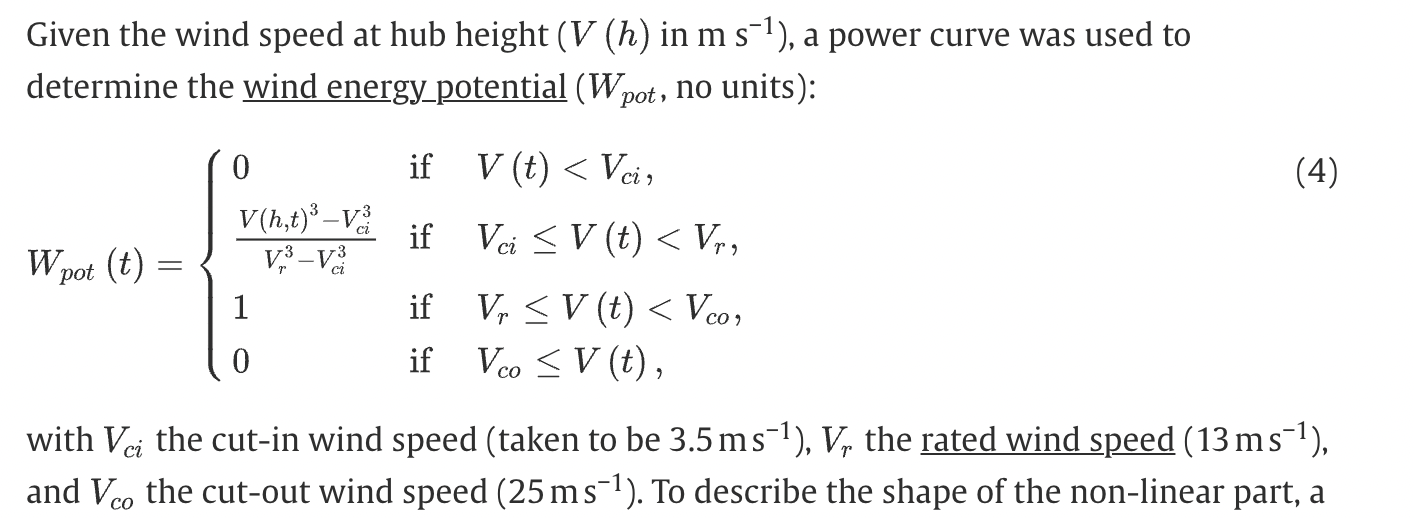

- Cut-in speed of 3 m/s here (pacific Hydro): https://onlinelibrary.wiley.com/doi/full/10.1111/aec.13220
- Cut-in, rated and cut-out of 4, 15, 25 here (slide 14; from 2008): https://www.engineersaustralia.org.au/sites/default/files/resource-files/2017-01/WindEnergyIEAustSHG060323.pdf

In [26]:
def capacity_factor_vdW(W):
    """
    Computes capacity factor from wind speed data.
    
    W: wind speed (m/s)
    """
    W_0 = 3.5 # cut-in speed (m/s)
    W_r = 13 # rated speed
    W_1 = 25 # cut-out speed (m/s)
    
    # Cubic
    c_f = (W ** 3 - W_0 ** 3) / (W_r ** 3 - W_0 ** 3)
    c_f = c_f.where(W >= W_0, 0) # Set values below cut-in to zero
    c_f = c_f.where(W < W_r, 1) # Set values above rated speed to 1
    c_f = c_f.where(W < W_1, 0) # Set values above cut-off to zero
    c_f = c_f.where(W.notnull(), np.nan) # Ensure NaNs are retained
    
    return c_f

In [22]:
vdw_cf = capacity_factor_vdW(w100)

In [23]:
vdw_cf = vdw_cf.chunk({"time": 365*10})

In [24]:
vdw_cf = vdw_cf.to_dataset(name="wind_cf")

In [25]:
write_path = "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/"

vdw_cf.to_zarr(
    write_path + "wind_capacity_factor_van_der_Wiel_era5_hourly_1959-2022_Aus.zarr",
    mode="w",
    consolidated=True
)

In [20]:
vdw_cf = xr.open_zarr(
    write_path + "wind_capacity_factor_van_der_Wiel_era5_hourly_1959-2022_Aus.zarr",
    consolidated=True
)

### Average capacity factor

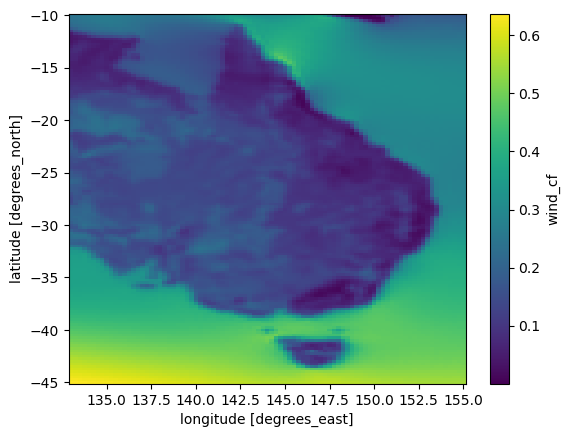

In [21]:
vdw_cf["wind_cf"].mean("time").plot()

### Difference between vdW and Gunn cfs

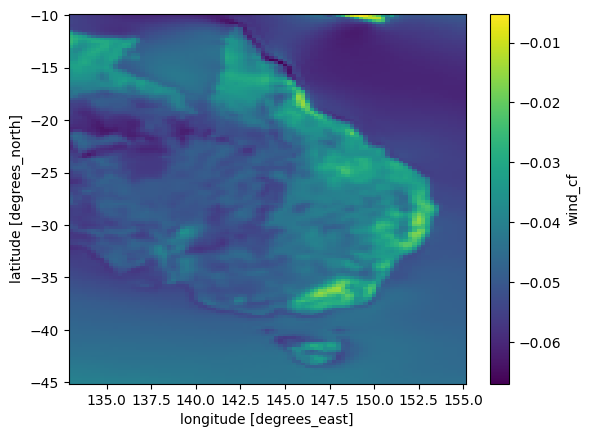

In [22]:
(vdw_cf["wind_cf"].mean("time") - gunn_cf["wind_cf"].mean("time")).plot()

### 2014-2015 time series for near Sydney

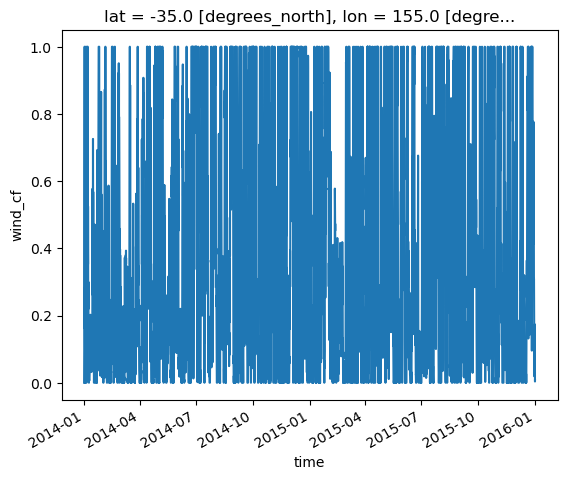

In [23]:
vdw_cf["wind_cf"].sel(lat=-35, lon=155, time=slice("2014", "2015")).plot()

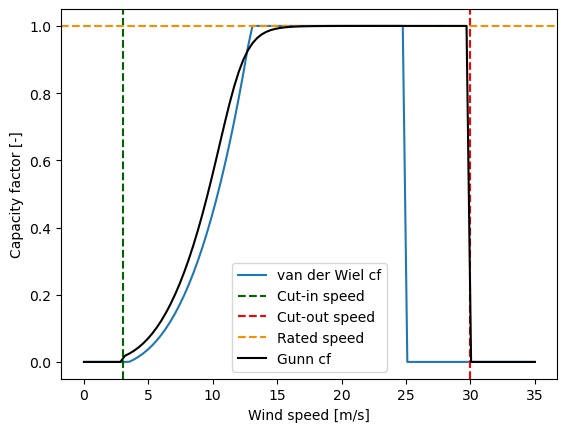

In [36]:
x = xr.DataArray(np.linspace(0, 35, 100))
p = capacity_factor_vdW(x)
p2 = capacity_factor(x)

fig, ax = plt.subplots(1, 1)
ax.plot(x, p, label="van der Wiel cf")
ax.axvline(3, ls="--", color="darkgreen", label="Cut-in speed")
ax.axvline(30, ls="--", color="r", label="Cut-out speed")
ax.axhline(1, ls="--", color="darkorange", label="Rated speed")
ax.set_xlabel("Wind speed [m/s]")
ax.set_ylabel("Capacity factor [-]")

ax.plot(x, p2, color="k", label="Gunn cf")

ax.legend()

# Close cluster

In [30]:
client.close()
cluster.close()